# Государственные деньги у НКО

**Задача** — проверить, есть ли зависимость вероятности получения грантов от государства / госконтрактов для некоммерческих организаций:

- от региона регистрации организации;
- возраста организации;
- экономической деятельности организации.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split

In [2]:
# Загружаем данные из дампа и собираем в один датафрейм.
filename_list = os.listdir('data/dump')

df_ngo = pd.read_json('data/dump/ngo_dump_01.json', lines=True)

for filename in filename_list[1:]:
    temp = pd.read_json('data/dump/' + filename, lines=True)
    df_ngo = pd.concat([df_ngo, temp])
    
df_ngo = df_ngo.reset_index(drop=True)

In [3]:
# Создадим копию датафрейма
df = df_ngo.copy()
    
df.head()

,minjustRegNum,regionName,logo,statusDetail,fullName,dateReg,minjustForm,charter,minjustStatus,ogrn,...,hasRegionalSupport,addOkved,okato,okfs,website_punycode,shortName,dateOgrn,predecessors,socialMedia,reports
0,7814061218,Санкт-Петербург,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...",МЕЖРЕГИОНАЛЬНАЯ АНТРОПОСОФСКАЯ МЕДИЦИНСКАЯ АСС...,None,"Объединения (союз, ассоциация) юридических лиц",NaN,Зарегистрирована,1207800141790,...,False,[],"{'name': None, 'code': None}","{'name': None, 'code': None}",None,"""АМА""",{'$date': '2020-10-30T00:00:00.000Z'},[],"{'youtube': None, 'vk': None, 'facebook': None...",[]
1,7714017452,Москва,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...","ФОНД ""СОДЕЙСТВИЕ ДУХОВНОМУ РАЗВИТИЮ ЧЕЛОВЕКА ""...",None,Некоммерческий фонд,NaN,Зарегистрирована,1207700349152,...,False,"[{'name': 'Издание книг', 'code': '58.11', 've...","{'name': None, 'code': None}","{'name': None, 'code': None}",None,"ФОНД ""УНИВЕРСАЛИСТ М""",{'$date': '2020-09-23T00:00:00.000Z'},[],"{'youtube': None, 'vk': None, 'facebook': None...","[{'localUrl': 'http://cdnx.h5.crftr.net/f/4,18..."
2,7814170160,Санкт-Петербург,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...","КОЛЛЕГИЯ АДВОКАТОВ ""САНКТ-ПЕТЕРБУРГСКАЯ КОЛЛЕГ...",None,Коллегия адвокатов,NaN,Зарегистрирована,1207800011430,...,False,[],"{'name': None, 'code': None}","{'name': None, 'code': None}",None,None,{'$date': '2020-02-03T00:00:00.000Z'},[],"{'youtube': None, 'vk': None, 'facebook': None...",[]
3,None,Москва,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...","ТОВАРИЩЕСТВО СОБСТВЕННИКОВ НЕДВИЖИМОСТИ ""ЛУГИН...",None,None,NaN,None,1207700348976,...,False,[{'name': 'Аренда и управление собственным или...,"{'name': None, 'code': None}","{'name': None, 'code': None}",None,"ТСН ""ЛУГИНИНО ПАРК""",{'$date': '2020-09-23T00:00:00.000Z'},[],"{'youtube': None, 'vk': None, 'facebook': None...",[]
4,7814052913,Санкт-Петербург,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...","АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ""ЦЕНТР С...",None,Автономная некоммерческая организация,NaN,Зарегистрирована,1207800081500,...,False,[{'name': 'Исследование конъюнктуры рынка и из...,"{'name': None, 'code': None}","{'name': None, 'code': None}",None,"АНО ""ЦЕНТР ""ПЕТЕРБУРГФОРУМ""",{'$date': '2020-07-08T00:00:00.000Z'},[],"{'youtube': None, 'vk': None, 'facebook': None...",[]


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747034 entries, 0 to 747033
Data columns (total 38 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   minjustRegNum       462302 non-null  object 
 1   regionName          747009 non-null  object 
 2   logo                0 non-null       float64
 3   statusDetail        747034 non-null  object 
 4   fullName            747034 non-null  object 
 5   dateReg             321416 non-null  object 
 6   minjustForm         462302 non-null  object 
 7   charter             0 non-null       float64
 8   minjustStatus       462302 non-null  object 
 9   ogrn                747034 non-null  int64  
 10  opf                 747034 non-null  object 
 11  oktmo               747034 non-null  object 
 12  egrulStatus         747034 non-null  object 
 13  mainOkved           747034 non-null  object 
 14  regionCode          747034 non-null  int64  
 15  incomeTotal         747034 non-nul

In [5]:
# Исклучим из выборки не действующие НКО.
mask = df['egrulStatus'] == 'Действует'
df = df[mask].reset_index(drop=True)

print('Количество записей', df.shape[0])

Количество записей 340900


In [6]:
# Определяем список признаков, у которых пропущенно более 30% значений.
#drop_list = (data.isnull().sum() / data.shape[0])[data.isnull().sum() / data.shape[0] > 0.3].index.to_list()
# Удаляем отобранные признаки.
#data = data.drop(drop_list, axis=1)

#print('Количество признаков после удаления:', data.shape[1])

Для определения возраста организации необходимо определить дату регистрации НКО. Для НКО, которые были зарегистрированы до 01.01.2002, дата регистрации указана в поле dateReg. Для НКО зарегистрированных позже 01.01.2002, датой регистрации организации считается дата присвоения ОГРН в ФНС (указана в поле dateOgrn). На основании изложенного заполним пропущенные значения признака dateReg значениями из признака dateOgrn.

In [7]:
mask = df['dateReg'].isna()

# Заполняем пропущенные значения.
df.loc[mask, 'dateReg'] = df.loc[mask, 'dateOgrn']

# Извлекаем дату регистрации из словаря и преобразовываем в datetime.
df['dateReg'] = df['dateReg'].apply(lambda x: x['$date'])
df['dateReg'] = pd.to_datetime(df['dateReg'])

# Создадим признак год регистрации.
df['year_reg'] = df['dateReg'].dt.year

df.head(2)

,minjustRegNum,regionName,logo,statusDetail,fullName,dateReg,minjustForm,charter,minjustStatus,ogrn,...,addOkved,okato,okfs,website_punycode,shortName,dateOgrn,predecessors,socialMedia,reports,year_reg
0,7814061218,Санкт-Петербург,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...",МЕЖРЕГИОНАЛЬНАЯ АНТРОПОСОФСКАЯ МЕДИЦИНСКАЯ АСС...,2020-10-30 00:00:00+00:00,"Объединения (союз, ассоциация) юридических лиц",NaN,Зарегистрирована,1207800141790,...,[],"{'name': None, 'code': None}","{'name': None, 'code': None}",None,"""АМА""",{'$date': '2020-10-30T00:00:00.000Z'},[],"{'youtube': None, 'vk': None, 'facebook': None...",[],2020
1,7714017452,Москва,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...","ФОНД ""СОДЕЙСТВИЕ ДУХОВНОМУ РАЗВИТИЮ ЧЕЛОВЕКА ""...",2020-09-23 00:00:00+00:00,Некоммерческий фонд,NaN,Зарегистрирована,1207700349152,...,"[{'name': 'Издание книг', 'code': '58.11', 've...","{'name': None, 'code': None}","{'name': None, 'code': None}",None,"ФОНД ""УНИВЕРСАЛИСТ М""",{'$date': '2020-09-23T00:00:00.000Z'},[],"{'youtube': None, 'vk': None, 'facebook': None...","[{'localUrl': 'http://cdnx.h5.crftr.net/f/4,18...",2020


Для каждой записи сформируем список  видов экономической деятельности кодов ОКВЭД, для этого из признака addOkved извлечем значения, соответствующие ключу name.
___
Структура записи признака addOkved:
```
[{'name': 'Работы строительные специализированные прочие, не включенные в другие группировки',
  'code': '43.99',
  'version': 'ОК 029-2014 (КДЕС Ред. 2)'},
 {'name': 'Производство растительных восков и дегры',
  'code': '10.41.7',
  'version': 'ОК 029-2014 (КДЕС Ред. 2)'}]
 ```

In [8]:
def okved_to_list(okved_record):
    okved_list = []
    
    for item in okved_record:
        okved_list.append(item['name'])
    
    if len(okved_list) > 0:
        return okved_list
    else:
        return np.nan


# Создаем признак okved, в который запишем список видов экономической деятельности НКО.
df['okved'] = df['addOkved'].apply(okved_to_list)

df.head(2)

,minjustRegNum,regionName,logo,statusDetail,fullName,dateReg,minjustForm,charter,minjustStatus,ogrn,...,okato,okfs,website_punycode,shortName,dateOgrn,predecessors,socialMedia,reports,year_reg,okved
0,7814061218,Санкт-Петербург,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...",МЕЖРЕГИОНАЛЬНАЯ АНТРОПОСОФСКАЯ МЕДИЦИНСКАЯ АСС...,2020-10-30 00:00:00+00:00,"Объединения (союз, ассоциация) юридических лиц",NaN,Зарегистрирована,1207800141790,...,"{'name': None, 'code': None}","{'name': None, 'code': None}",None,"""АМА""",{'$date': '2020-10-30T00:00:00.000Z'},[],"{'youtube': None, 'vk': None, 'facebook': None...",[],2020,NaN
1,7714017452,Москва,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...","ФОНД ""СОДЕЙСТВИЕ ДУХОВНОМУ РАЗВИТИЮ ЧЕЛОВЕКА ""...",2020-09-23 00:00:00+00:00,Некоммерческий фонд,NaN,Зарегистрирована,1207700349152,...,"{'name': None, 'code': None}","{'name': None, 'code': None}",None,"ФОНД ""УНИВЕРСАЛИСТ М""",{'$date': '2020-09-23T00:00:00.000Z'},[],"{'youtube': None, 'vk': None, 'facebook': None...","[{'localUrl': 'http://cdnx.h5.crftr.net/f/4,18...",2020,"[Издание книг, Издание газет, Виды издательско..."


In [9]:
# Удалим записи, у которых не указан вид экономической деятельности.
df = df.dropna(subset='okved')

print('Количество записей', df.shape[0])

Количество записей 153554


Для каждой НКО извлечем данные о заключенных госконтрактах и полученных президентских грантах. Так как нас не интересует сумма госконтракта / гранта, а необходимо зафиксировать лишь факт получения гранта или заключения госконтракта, будем извлекать только год получения гранта / заключения госконтракта из признака incomeDetail.
___
Структура записи признака incomeDetail:
```
{'grants': {'totalCount': 0, 'totalSum': 0},
 'fedSubsidies': {'totalCount': 0, 'totalSum': 0},
 'contracts44': {'totalCount': 9,
  'totalSum': 1096727.62,
  '2021': {'sum': 1096727.62, 'count': 9}},
 'contracts223': {'totalCount': 0, 'totalSum': 0},
 'contracts94': {'totalCount': 0, 'totalSum': 0}}
 ```
___
Из структуры записи, видим, что в случае если НКО не получала грантов и не заключала госконтраков, то в соответствующем словаре присутствуют записи с ключами totalCount и totalSum, в противном случае появляются дополнительные записи, где в качестве ключа используется год получения гранта / заключения госконтракта. Таким образом для извлечения необходимых данных будем искать ключи отличные от totalCount и totalSum и добавлять их в список.

In [10]:
def year_contract_grant_to_list(row, keys_list):
    
    year_list = []
    exception_list = ['totalCount', 'totalSum']
    
    for key in keys_list:
        for item in row[key].keys():
            if item not in exception_list and int(item) not in year_list:
                year_list.append(int(item))
                
    return year_list


# Создаем признак contract_year, в который запишем список, 
# содержащий года заключения госконтрактов.
df['contract_year'] = (
    df['incomeDetail']
    .apply(lambda x: year_contract_grant_to_list(x, ['contracts44', 'contracts223', 'contracts94']))
)
# Создаем признак contract_grant_year, в который запишем список, 
# содержащий года получения грантов.
df['grant_year'] = (
    df['incomeDetail']
    .apply(lambda x: year_contract_grant_to_list(x, ['grants']))
)

df.head(2)

,minjustRegNum,regionName,logo,statusDetail,fullName,dateReg,minjustForm,charter,minjustStatus,ogrn,...,website_punycode,shortName,dateOgrn,predecessors,socialMedia,reports,year_reg,okved,contract_year,grant_year
1,7714017452,Москва,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...","ФОНД ""СОДЕЙСТВИЕ ДУХОВНОМУ РАЗВИТИЮ ЧЕЛОВЕКА ""...",2020-09-23 00:00:00+00:00,Некоммерческий фонд,NaN,Зарегистрирована,1207700349152,...,None,"ФОНД ""УНИВЕРСАЛИСТ М""",{'$date': '2020-09-23T00:00:00.000Z'},[],"{'youtube': None, 'vk': None, 'facebook': None...","[{'localUrl': 'http://cdnx.h5.crftr.net/f/4,18...",2020,"[Издание книг, Издание газет, Виды издательско...",[],[]
3,None,Москва,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...","ТОВАРИЩЕСТВО СОБСТВЕННИКОВ НЕДВИЖИМОСТИ ""ЛУГИН...",2020-09-23 00:00:00+00:00,None,NaN,None,1207700348976,...,None,"ТСН ""ЛУГИНИНО ПАРК""",{'$date': '2020-09-23T00:00:00.000Z'},[],"{'youtube': None, 'vk': None, 'facebook': None...",[],2020,[Аренда и управление собственным или арендован...,[],[]


Согласно информации о проекте "Открытые НКО", в рамках проекта предоставляется информация о победителях президентских грантов с 2013 года и заключенных госконтрактах с 2011 года. В дампе базы данных представлены данные по состоянию на 26.08.2021. Таким образом оценка зависимости должна производится в период с 2011 по 2021 года. Для этого добавим в датафрейм признак year, в котором для каждой НКО будет содержаться список лет с 2011 года (года регистрации, если НКО зарегистрирована после 2011 года) по 2021 год.

In [11]:
# Создаем новый признак year.
df['year'] = df['year_reg'].apply(lambda x: [i for i in range(max(x, 2011), 2022)])

df.head(2)

,minjustRegNum,regionName,logo,statusDetail,fullName,dateReg,minjustForm,charter,minjustStatus,ogrn,...,shortName,dateOgrn,predecessors,socialMedia,reports,year_reg,okved,contract_year,grant_year,year
1,7714017452,Москва,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...","ФОНД ""СОДЕЙСТВИЕ ДУХОВНОМУ РАЗВИТИЮ ЧЕЛОВЕКА ""...",2020-09-23 00:00:00+00:00,Некоммерческий фонд,NaN,Зарегистрирована,1207700349152,...,"ФОНД ""УНИВЕРСАЛИСТ М""",{'$date': '2020-09-23T00:00:00.000Z'},[],"{'youtube': None, 'vk': None, 'facebook': None...","[{'localUrl': 'http://cdnx.h5.crftr.net/f/4,18...",2020,"[Издание книг, Издание газет, Виды издательско...",[],[],"[2020, 2021]"
3,None,Москва,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...","ТОВАРИЩЕСТВО СОБСТВЕННИКОВ НЕДВИЖИМОСТИ ""ЛУГИН...",2020-09-23 00:00:00+00:00,None,NaN,None,1207700348976,...,"ТСН ""ЛУГИНИНО ПАРК""",{'$date': '2020-09-23T00:00:00.000Z'},[],"{'youtube': None, 'vk': None, 'facebook': None...",[],2020,[Аренда и управление собственным или арендован...,[],[],"[2020, 2021]"


In [12]:
# Извлечем даныые из спискоков значений признаков year, grant_year и contract_year.
df = df.explode('year')
df = df.explode('grant_year')
df = df.explode('contract_year')

# Рассчитаем возраст каждого НКО.
df['ngo_age'] = (df['year'] - df['year_reg']).astype('int')

# Рассчитаем целевую переменную had_grant_contract, 
# в которой будет хранится информация получала ли НКО грант 
# / заключала госконтракт в указанный год:
# 0 - НКО не получала грант и не заключала госконтракт;
df['has_grant_contract'] = 0
# 1 - НКО получала грант, но не заключала госконтракт;
mask_1 = (df['grant_year'] == df['year']) & (df['contract_year'] != df['year'])
df.loc[mask_1, 'has_grant_contract'] = 1
# 2 - НКО не получала грант, но заключала госконтракт;
mask_2 = (df['grant_year'] != df['year']) & (df['contract_year'] == df['year'])
df.loc[mask_2, 'has_grant_contract'] = 2
# 3 - НКО получала грант, и заключала госконтракт.
mask_3 = (df['grant_year'] == df['year']) & (df['contract_year'] == df['year'])
df.loc[mask_3, 'has_grant_contract'] = 3

df.head()

,minjustRegNum,regionName,logo,statusDetail,fullName,dateReg,minjustForm,charter,minjustStatus,ogrn,...,predecessors,socialMedia,reports,year_reg,okved,contract_year,grant_year,year,ngo_age,has_grant_contract
1,7714017452,Москва,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...","ФОНД ""СОДЕЙСТВИЕ ДУХОВНОМУ РАЗВИТИЮ ЧЕЛОВЕКА ""...",2020-09-23 00:00:00+00:00,Некоммерческий фонд,NaN,Зарегистрирована,1207700349152,...,[],"{'youtube': None, 'vk': None, 'facebook': None...","[{'localUrl': 'http://cdnx.h5.crftr.net/f/4,18...",2020,"[Издание книг, Издание газет, Виды издательско...",NaN,NaN,2020,0,0
1,7714017452,Москва,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...","ФОНД ""СОДЕЙСТВИЕ ДУХОВНОМУ РАЗВИТИЮ ЧЕЛОВЕКА ""...",2020-09-23 00:00:00+00:00,Некоммерческий фонд,NaN,Зарегистрирована,1207700349152,...,[],"{'youtube': None, 'vk': None, 'facebook': None...","[{'localUrl': 'http://cdnx.h5.crftr.net/f/4,18...",2020,"[Издание книг, Издание газет, Виды издательско...",NaN,NaN,2021,1,0
3,None,Москва,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...","ТОВАРИЩЕСТВО СОБСТВЕННИКОВ НЕДВИЖИМОСТИ ""ЛУГИН...",2020-09-23 00:00:00+00:00,None,NaN,None,1207700348976,...,[],"{'youtube': None, 'vk': None, 'facebook': None...",[],2020,[Аренда и управление собственным или арендован...,NaN,NaN,2020,0,0
3,None,Москва,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...","ТОВАРИЩЕСТВО СОБСТВЕННИКОВ НЕДВИЖИМОСТИ ""ЛУГИН...",2020-09-23 00:00:00+00:00,None,NaN,None,1207700348976,...,[],"{'youtube': None, 'vk': None, 'facebook': None...",[],2020,[Аренда и управление собственным или арендован...,NaN,NaN,2021,1,0
4,7814052913,Санкт-Петербург,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...","АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ""ЦЕНТР С...",2020-07-08 00:00:00+00:00,Автономная некоммерческая организация,NaN,Зарегистрирована,1207800081500,...,[],"{'youtube': None, 'vk': None, 'facebook': None...",[],2020,[Исследование конъюнктуры рынка и изучение общ...,NaN,NaN,2020,0,0


In [13]:
# Удалим дублирующие записи, возникшие при разворачивание списков.
df = df.drop_duplicates(subset=['ogrn', 'year', 'has_grant_contract'])

print('Количество записей', df.shape[0])

Количество записей 1251804


In [14]:
# Построим описательные статистики для интересующих нас признаков.
df[['regionName', 'ngo_age', 'has_grant_contract']].describe(include='all')

,regionName,ngo_age,has_grant_contract
count,1251804,1.251804e+06,1.251804e+06
unique,86,NaN,NaN
top,Москва,NaN,NaN
freq,178229,NaN,NaN
mean,NaN,8.736114e+00,8.814239e-02
std,NaN,7.555629e+00,4.019913e-01
min,NaN,0.000000e+00,0.000000e+00
25%,NaN,3.000000e+00,0.000000e+00
50%,NaN,7.000000e+00,0.000000e+00
75%,NaN,1.300000e+01,0.000000e+00


In [15]:
# Распределение НКО по регионам.
df['regionName'].value_counts(normalize=True) * 100

Москва                          14.237772
Московская область               7.759202
Санкт-Петербург                  4.339577
Свердловская область             2.982096
Краснодарский край               2.914833
                                  ...    
Республика Ингушетия             0.119108
Еврейская автономная область     0.102732
Ненецкий автономный округ        0.070139
Чукотский автономный округ       0.055360
Не определено                    0.010305
Name: regionName, Length: 86, dtype: float64

В признаке regionName присутствуют пропущенные значения (данным записям соответствует значение "Не определено"). Удалим указанные записи из датафрейма.

In [16]:
mask = df['regionName'] != 'Не определено'
df = df[mask]

print('Количество записей', df.shape[0])

Количество записей 1251675


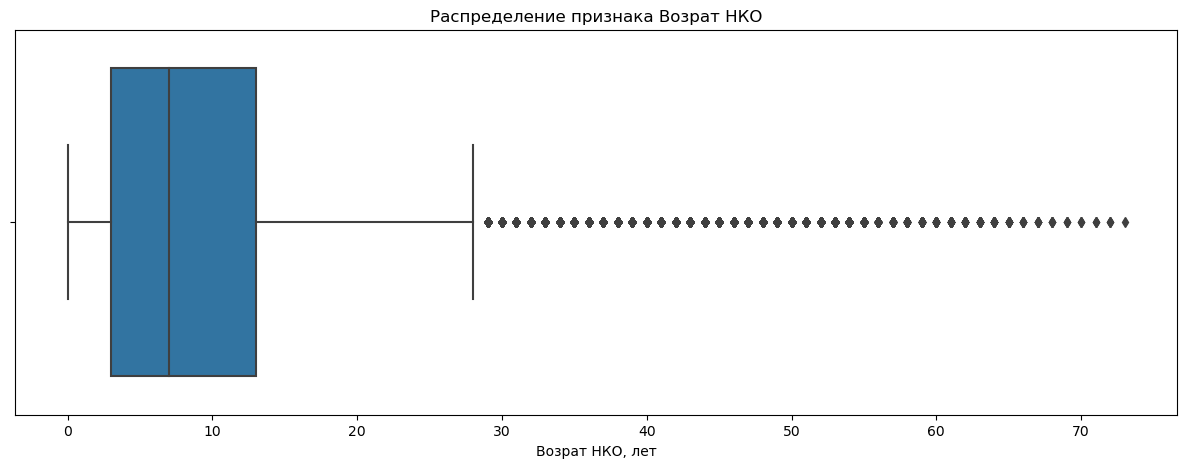

In [17]:
# Распределение признака ngo_age.
fig = plt.figure(figsize=(15, 5))

boxplot = sns.boxplot(x=df['ngo_age'])
boxplot.set_title('Распределение признака Возрат НКО')
boxplot.set_xlabel('Возрат НКО, лет');

Из построенного графика видим, что в выборке присутствуют НКО возраст которых превышает 30 лет и находиятся за границами межквартильного размаха. Подробнее рассмотрим данные НКО.

In [18]:
mask = df['ngo_age'] > 30

print('Количество НКО старше 30 лет:', df[mask]['ogrn'].nunique())

print('Среднее значение целевой переменной:', df[mask]['has_grant_contract'].mean())

# ТОП-5 НКО в разрезе формы НКО (согласно системе Минюста РФ).
df[mask]['minjustForm'].value_counts(normalize=True).head()

Количество НКО старше 30 лет: 2362
Среднее значение целевой переменной: 0.012545501820072804


Садоводческие, огороднические, дачные и иные некоммерческие товарищества    0.959704
Товарищество собственников жилья                                            0.015285
Общественная организация                                                    0.008183
Садоводческое, огородническое, дачное некоммерческое партнерство            0.005713
Объединения (союз, ассоциация) юридических лиц                              0.005558
Name: minjustForm, dtype: float64

Из дополнительной информации видим, что количество НКО старше 30 лет превышает 2 тыс. организаций, практически все эти НКО - это Садоводческие, огороднические, дачные и иные некоммерческие товарищества). То есть это не единичные выбросы, кроме того среди данных НКО присутствуют получатели президентских грантов и исполнители госконтрактов. На основании изложенного, нет оснований считать данные записи выбросами и исключать их из выборки.

In [19]:
# Создадим датафрейм, в котором для каждого вида экономической деятельности рассчитаем
# количество записей в %, у которых указан данный вид экономической деятельности по убыванию.
okved_data = (
    df.explode('okved')['okved']
    .value_counts(normalize=True)
    .reset_index()
    .rename({'index': 'okved_name', 'okved': 'ngo_cnt'}, axis=1)
)

# Добавим кумулятивный признак количества записей в %.
okved_data['cum_ngo_cnt'] = okved_data['ngo_cnt'].cumsum()

okved_data

,okved_name,ngo_cnt,cum_ngo_cnt
0,Деятельность в области спорта прочая,2.225519e-02,0.022255
1,Управление эксплуатацией нежилого фонда за воз...,1.579083e-02,0.038046
2,Аренда и управление собственным или арендованн...,1.450049e-02,0.052547
3,Деятельность по дополнительному профессиональн...,1.383393e-02,0.066380
4,Деятельность по предоставлению прочих вспомога...,1.332836e-02,0.079709
...,...,...,...
2291,"Деятельность почтовой связи, связанная с перес...",1.393903e-07,0.999999
2292,"Производство обуви, кроме спортивной, защитной...",1.393903e-07,1.000000
2293,"Производство гетр, гамашей и аналогичных изделий",1.393903e-07,1.000000
2294,Торговля оптовая легковыми автомобилями и легк...,1.393903e-07,1.000000


В признаке okved 2296 уникальных значений. Для сокращения количества уникальных категорий в указанном признаке, рассчитаем наиболее распространненые виды экономической деятельности.

Количество видов экономической деятельности в 90% записей, составляет: 478


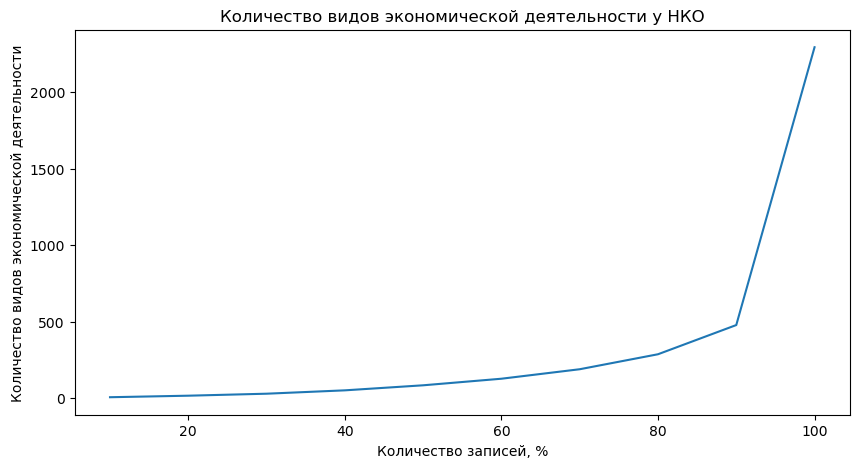

In [20]:
# Построим график, показывающий какое количество видов экономической деятельности 
# наиболее часто встречается у НКО.  
okved_data_grouped = dict()
for i in range(10, 110, 10):
    okved_data_grouped[i] = okved_data[okved_data['cum_ngo_cnt'] <= i / 100].shape[0]
    
fig = plt.figure(figsize=(10, 5))

line = sns.lineplot(
    x=okved_data_grouped.keys(),
    y=okved_data_grouped.values()
)
line.set_title('Количество видов экономической деятельности у НКО')
line.set_xlabel('Количество записей, %')
line.set_ylabel('Количество видов экономической деятельности');
print('Количество видов экономической деятельности в 90% записей, составляет:', okved_data_grouped[90])

**Вывод:** из полученных данных видим, что в 90% всех записей всречаются только 478 видов экономической деятельности, остальные 1,8 тыс. видов экономической деятельности указаны в оставшихся 10% записей. Соответственно, мы можем объеденить 1,8 тыс. видов экономической деятельности в одну категорию "Прочая деятельность", тем самым сократив количество признаков в обуающей выборке практически на 2 тыс. с минимальными потерями информативности признака.

In [21]:
# Создадим списки видов экономической деятельности.
basic_okved_list = okved_data[okved_data['cum_ngo_cnt'] <= 0.9]['okved_name'].to_list()
other_okved_list = okved_data[okved_data['cum_ngo_cnt'] > 0.9]['okved_name'].to_list()

# Создаем новый датафрей, в котором будут содержаться только признаки,
# представляемые интерес для решения поставленной задачи.
columns = ['regionName', 'okved', 'ngo_age', 'has_grant_contract']
data = df[columns].reset_index(drop=True)

data.head()

,regionName,okved,ngo_age,has_grant_contract
0,Москва,"[Издание книг, Издание газет, Виды издательско...",0,0
1,Москва,"[Издание книг, Издание газет, Виды издательско...",1,0
2,Москва,[Аренда и управление собственным или арендован...,0,0
3,Москва,[Аренда и управление собственным или арендован...,1,0
4,Санкт-Петербург,[Исследование конъюнктуры рынка и изучение общ...,0,0


In [22]:
# Создадим признаки для видов экономической деятельности и заполним их 0.
for name in basic_okved_list:
    data[name] = 0
    
data['Прочая деятельность'] = 0

# Извлечем даныые из спискоков значений признака okved.
for i in data.index:
    for item in data.loc[i, 'okved']:
        if item in basic_okved_list:
            data.loc[i, item] = 1
        elif item in other_okved_list:
            data.loc[i, 'Прочая деятельность'] = 1
            
data = data.drop(['okved'], axis=1)

# закодируем признак regionName.
data = pd.get_dummies(data, columns=['regionName'])

data.head()

,ngo_age,has_grant_contract,Деятельность в области спорта прочая,Управление эксплуатацией нежилого фонда за вознаграждение или на договорной основе,Аренда и управление собственным или арендованным недвижимым имуществом,"Деятельность по дополнительному профессиональному образованию прочая, не включенная в другие группировки","Деятельность по предоставлению прочих вспомогательных услуг для бизнеса, не включенная в другие группировки",Строительство жилых и нежилых зданий,Консультирование по вопросам коммерческой деятельности и управления,"Деятельность зрелищно-развлекательная прочая, не включенная в другие группировки",...,regionName_Удмуртская республика,regionName_Ульяновская область,regionName_Хабаровский край,regionName_Ханты-Мансийский автономный округ - Югра,regionName_Челябинская область,regionName_Чеченская республика,regionName_Чувашская республика,regionName_Чукотский автономный округ,regionName_Ямало-Ненецкий автономный округ,regionName_Ярославская область
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [23]:
#Записываем полученные данные в csv файл.
data.to_csv('data/ngo_data.csv', index=False)